In [80]:
import pandas as pd
import os
import numpy as np
import h5py

The training loop

Using the actual dataset from the matlab file given instead.

In [81]:
mat_file = "original_dataset/ReadBrownDwarf.mat"
data_path = "original_dataset/"
idTE = np.load(data_path + "idTE.npy")
idTR = np.load(data_path + "idTR.npy")
labelTE = np.load(data_path + "labelTE.npy")
labelTR = np.load(data_path + "labelTR.npy")

In [82]:
#Extracting the data from the mat file
with h5py.File(mat_file, 'r') as f:
    data = f["data"]
    data = pd.DataFrame(data).T
data = data.replace(0, data.mean())
data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,326.808170,2.686124,5.556000,0.011525,5.760000,0.015613,5.947000,0.015597,6.072000,0.01689,...,0.162,0.050,0.015,0.044000,5.562,5.539,5.479,0.017,0.026,0.020
1,321.200440,25.880459,10.475293,0.011525,7.611600,0.001000,13.076002,0.015597,7.516700,0.00100,...,0.059,0.020,0.016,0.059000,6.896,6.921,6.932,0.026,0.024,0.016
2,144.038450,-12.459262,10.512000,0.011525,10.692000,0.015613,10.866000,0.015597,10.989000,0.01689,...,0.022,0.020,0.074,0.031882,10.408,10.400,10.378,0.026,0.021,0.023
3,209.662170,21.696203,10.475293,0.011525,11.509565,0.015613,6.860300,0.104200,13.834022,0.01689,...,0.149,0.046,0.015,0.037000,5.671,5.717,5.704,0.023,0.063,0.020
4,65.162550,-20.639620,10.475293,0.011525,11.509565,0.015613,6.320600,0.015597,5.950400,0.00310,...,0.169,0.072,0.015,0.036000,5.430,5.402,5.333,0.054,0.036,0.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664,13.245956,49.443574,9.122700,0.234700,9.182300,0.001000,13.076002,0.015597,9.006600,0.00100,...,0.022,0.019,0.021,0.144000,8.358,8.389,8.398,0.027,0.017,0.016
5665,29.647854,48.432832,10.475293,0.011525,9.553800,0.001000,13.076002,0.015597,10.725300,0.00100,...,0.023,0.019,0.026,0.297000,8.778,8.804,8.766,0.021,0.016,0.020
5666,346.990957,54.326940,10.475293,0.011525,9.840500,0.001000,9.202500,0.001000,10.108900,0.03740,...,0.024,0.020,0.030,0.327000,9.180,9.187,9.180,0.021,0.020,0.022
5667,331.173131,46.427253,10.491500,0.063000,10.253800,0.023900,10.005700,0.007400,10.441800,0.03150,...,0.023,0.020,0.033,0.031882,9.693,9.678,9.622,0.024,0.029,0.023


In [83]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
for i in range(len(idTR)):
    X_train_list.append(data.iloc[idTR[i] - 1]) #idTR is 1 indexed
    X_test_list.append(data.iloc[idTE[i] - 1])  #idTE is 1 indexed
    y_train_list.append(labelTR[i])
    y_test_list.append(labelTE[i])

X_train_arr = np.array(X_train_list)
X_test_arr = np.array(X_test_list)
y_train_arr = np.array(y_train_list)
y_test_arr = np.array(y_test_list)

In [84]:
X_train_arr.shape, X_test_arr.shape, y_train_arr.shape, y_test_arr.shape

((5, 4535, 26), (5, 1134, 26), (5, 4535), (5, 1134))

Added scaling here

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_arr_reshaped = X_train_arr.reshape(-1,26) #mixing all folds together before applying PCA
X_test_arr_reshaped = X_test_arr.reshape(-1,26)

X_train_arr_reshaped = scaler.fit_transform(X_train_arr_reshaped)
X_test_arr_reshaped = scaler.transform(X_test_arr_reshaped)


In [86]:
from sklearn.decomposition import PCA

pca = PCA(n_components=13)


pca.fit(X_train_arr_reshaped)
X_train_arr = pca.transform(X_train_arr_reshaped)
X_test_arr = pca.transform(X_test_arr_reshaped)
X_train_arr = X_train_arr.reshape(5,4535,13) #reshaping back to original shape
X_test_arr = X_test_arr.reshape(5,1134,13)

In [87]:
X_train_arr.shape, X_test_arr.shape, y_train_arr.shape, y_test_arr.shape

((5, 4535, 13), (5, 1134, 13), (5, 4535), (5, 1134))

Neural Net for binary classification 5x32x64x32x1

# NN

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays or pandas DataFrames to PyTorch tensors if needed
X_train_tens = torch.tensor(X_train_arr, dtype=torch.float32)
y_train_tens = torch.tensor(y_train_arr, dtype=torch.long)

# Defining a simple neural network class for binary classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.activation = activation       
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)# Output layer with single neuron (binary classification)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid activation for binary classification of final output
        return x


## Training loop

In [89]:
SEED = 1
torch.manual_seed(SEED) # Added seed for reproducibility for all the activation functions
act_losses = [] 
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Hardtanh()]
act_colors = {"ReLU": "red", "Sigmoid": "blue", "Tanh": "green", "Hardtanh": "orange"}
for act in activation_functions:
    losses = []
    for i in range(len(X_train_tens)):
        # Initialize the neural network
        input_size = X_train_tens[i].shape[1]
        model = NeuralNet(input_size, act)
        # if i > 0:
        #     model.load_state_dict(torch.load(f'models/activation_test/{type(act).__name__}/fold{i-1}_binary_classification_model.pth')) #Reuses the model from the previous fold

        # Define loss function and optimizer
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = optim.Adam(model.parameters())

        # Prepare data for training using DataLoader
        batch_size = 64
        train_dataset = TensorDataset(X_train_tens[i], y_train_tens[i])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Training loop
        num_epochs = 15
        temp_loss = []
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                outputs = outputs.squeeze(dim=1)  # Remove extra dimension for binary classification
                loss = criterion(outputs, labels.float())  # Calculate loss

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
            temp_loss.append(running_loss / len(train_loader))
        losses.append(temp_loss)

        # Assuming X_test is your test data
        model.eval()  #Switch to evaluation mode
        with torch.no_grad():
            predictions = model(X_train_tens[i])
            predictions = (predictions > 0.5).int()  # Convert probabilities to binary predictions (0 or 1)


        model_dir = f'./models/activation_test/{type(act).__name__}/'
        # Check if the directory exists
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        #Saving the model for later use
        model_path = os.path.join(model_dir, f'fold{i}_binary_classification_model.pth')
        torch.save(model.state_dict(), model_path)
    act_losses.append(losses)

Epoch 1, Loss: 0.47892304751234993
Epoch 2, Loss: 0.12806053601310285
Epoch 3, Loss: 0.0799138723334796
Epoch 4, Loss: 0.0681328975241369
Epoch 5, Loss: 0.06144351428243476
Epoch 6, Loss: 0.05616631629076642
Epoch 7, Loss: 0.05354240358295575
Epoch 8, Loss: 0.05069505823382609
Epoch 9, Loss: 0.04884959952774602
Epoch 10, Loss: 0.04698672851311489
Epoch 11, Loss: 0.04550062499048425
Epoch 12, Loss: 0.04452438589552758
Epoch 13, Loss: 0.04313938927666192
Epoch 14, Loss: 0.04270881224213771
Epoch 15, Loss: 0.041584887377865296
Epoch 1, Loss: 0.43524996684470646
Epoch 2, Loss: 0.12089713106692677
Epoch 3, Loss: 0.08354659249979846
Epoch 4, Loss: 0.07264401067153249
Epoch 5, Loss: 0.06592705995369126
Epoch 6, Loss: 0.06085967147906481
Epoch 7, Loss: 0.05749646296173754
Epoch 8, Loss: 0.05553878123648989
Epoch 9, Loss: 0.05360469352585119
Epoch 10, Loss: 0.051806626231475195
Epoch 11, Loss: 0.05114712232959942
Epoch 12, Loss: 0.04977022216353618
Epoch 13, Loss: 0.04914346530797406
Epoch 14, 

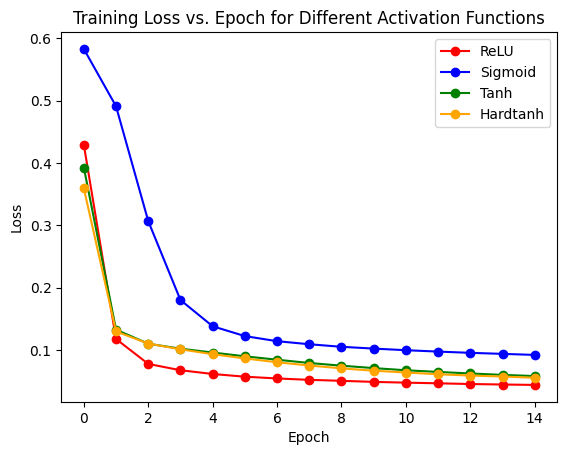

In [90]:
import matplotlib.pyplot as plt

act_mean_losses = np.mean(act_losses, axis=1) #Mean loss for each activation function

for i, loss in enumerate(act_mean_losses):
    name_act = type(activation_functions[i]).__name__
    c = act_colors[name_act]
    plt.plot(loss, "-o", label=name_act, color = c)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch for Different Activation Functions")
plt.show()

### Testing last epoch on training data

In [91]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

for act in activation_functions:
    print(f"Activation function: {type(act).__name__}")
    for i in range(len(X_train_tens)):
        print(f"Evaluating model on fold: {i}")
        # Load the trained model
        input_size = input_size  
        model = NeuralNet(input_size, act)
        model.load_state_dict(torch.load(f'models/activation_test/{type(act).__name__}/fold{i}_binary_classification_model.pth')) 


        X_train = X_train_tens[i].float()
        y_train = y_train_tens[i].float()

        #Prepare test dataset and dataloader
        batch_size = 64
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  #No need to shuffle for testing

        model.eval()  #Switch to evaluation mode
        y_true = []
        y_pred = []
        with torch.no_grad(): #No need for gradient on test run
            for inputs, labels in train_loader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Calculate Matthews Correlation Coefficient (MCC)
        mcc_tr = matthews_corrcoef(y_true, y_pred)

        print(f"Training: MCC-score: {mcc_tr}, check against the test set for overfitting")


Activation function: ReLU
Evaluating model on fold: 0
Training: MCC-score: 0.9692214190503673, check against the test set for overfitting
Evaluating model on fold: 1
Training: MCC-score: 0.9675154817127322, check against the test set for overfitting
Evaluating model on fold: 2
Training: MCC-score: 0.972973267996903, check against the test set for overfitting
Evaluating model on fold: 3
Training: MCC-score: 0.9664986598176901, check against the test set for overfitting
Evaluating model on fold: 4
Training: MCC-score: 0.9713478765632145, check against the test set for overfitting
Activation function: Sigmoid
Evaluating model on fold: 0
Training: MCC-score: 0.9430666340741218, check against the test set for overfitting
Evaluating model on fold: 1
Training: MCC-score: 0.9480643736114617, check against the test set for overfitting
Evaluating model on fold: 2
Training: MCC-score: 0.9474856613742954, check against the test set for overfitting
Evaluating model on fold: 3
Training: MCC-score: 0

### Testing the model on the test set

In [106]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix


act_all_metrics = {}
act_mean_metrics = {}
act_all_confusion_matrices = {}
act_mean_confusion_matrices = {}

for act in activation_functions:
    all_metrics = {}
    all_confusion_matrices = {}
    act_name = type(act).__name__
    print(f"Activation function: {act_name}")
    print("---------------------------------")
    temp_F1, temp_MCC, temp_acc, temp_prec, temp_rec = 0,0,0,0,0
    for i in range(len(X_train_tens)):
        print(f"    Evaluating model on fold: {i}")
        # Load the trained model
        input_size = input_size  # Assuming the input size based on X_train
        model = NeuralNet(input_size, act)
        model.load_state_dict(torch.load(f'models/activation_test/{act_name}/fold{i}_binary_classification_model.pth'))  # Load the trained model state 

        X_test = torch.tensor(X_test_arr[i], dtype=torch.float32)
        y_test = torch.tensor(y_test_arr[i], dtype=torch.float32)

        #Prepare test dataset and dataloader
        batch_size = 64
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #No need to shuffle for testing

        model.eval()  #Switch to evaluation mode
        y_true = []
        y_pred = []
        with torch.no_grad(): #No need to calculate gradients in test run
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred)

        #Calculate Matthews Correlation Coefficient (MCC)
        mcc = matthews_corrcoef(y_true, y_pred)

        #Computes accuracy, precision, recall and conf. matrix
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary') #Binary average, since we have a binary classification problem
        recall = recall_score(y_true, y_pred, average='binary')  
        conf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])

        #Stores the metrics in a dictionary for easy plotting
        metrics = {'F1 Score': f1, 'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
        temp_F1 += f1
        temp_MCC += mcc
        temp_acc += accuracy
        temp_prec += precision
        temp_rec += recall
        temp_MCC += mcc
        all_metrics[f"fold_{i}"] = metrics
        all_confusion_matrices[f"fold_{i}"] = conf_matrix
        print(f"Testing: {metrics['MCC']}")
    print("---------------------------------")
    print("\n")
    #Saving the metrics and confusion matrices with respective act. func. for later use
    act_all_metrics[act_name] = all_metrics
    act_all_confusion_matrices[act_name] = all_confusion_matrices
    act_mean_metrics[act_name] = {'F1 Score': temp_F1/len(X_train_tens), 'MCC': temp_MCC/len(X_train_tens), 'Accuracy': temp_acc/len(X_train_tens), 'Precision': temp_prec/len(X_train_tens), 'Recall': temp_rec/len(X_train_tens)}
    act_mean_confusion_matrices[act_name] = temp_MCC/len(X_train_tens)


Activation function: ReLU
---------------------------------
    Evaluating model on fold: 0
Testing: 0.9610026963710521
    Evaluating model on fold: 1
Testing: 0.9783979775247849
    Evaluating model on fold: 2
Testing: 0.9543337988415426
    Evaluating model on fold: 3
Testing: 0.9717313477184224
    Evaluating model on fold: 4
Testing: 0.9510417726518531
---------------------------------


Activation function: Sigmoid
---------------------------------
    Evaluating model on fold: 0
Testing: 0.9453288214064902
    Evaluating model on fold: 1
Testing: 0.9363458144126854
    Evaluating model on fold: 2
Testing: 0.9408837066694068
    Evaluating model on fold: 3
Testing: 0.9562983788760585
    Evaluating model on fold: 4
Testing: 0.9435478941861205
---------------------------------


Activation function: Tanh
---------------------------------
    Evaluating model on fold: 0
Testing: 0.956556426077473
    Evaluating model on fold: 1
Testing: 0.9718401797621335
    Evaluating model on fo

## Metrics comparison

Text(0.5, 1.0, 'Metrics for Different Activation Functions')

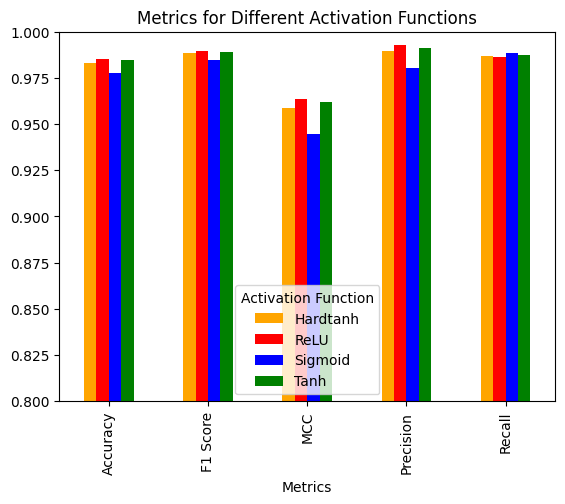

In [99]:
data_metric = pd.DataFrame(act_mean_metrics)
#Reset the index to make 'Metrics' a column
data_metric = data_metric.reset_index().rename(columns={'index': 'Metrics'})


data_metric = pd.melt(data_metric, id_vars='Metrics', var_name='Activation Function', value_name='Value')

data_metric = data_metric.set_index(['Metrics', 'Activation Function']).Value
colors = ["orange", "red", "blue", "green"]
data_metric.unstack().plot(kind='bar', stacked=False, color = colors)
plt.ylim(0.8,1)
plt.title("Metrics for Different Activation Functions")

In [113]:
act_mean_confusion_matrices
# act_all_confusion_matrices
act_all_confusion_matrices

mean_confusion_matrices = {}
for act_func, matrices in act_all_confusion_matrices.items():
    stacked_matrices = np.dstack(list(matrices.values()))
    mean_matrix = np.mean(stacked_matrices, axis=2, dtype=int)
    mean_confusion_matrices[act_func] = mean_matrix

print(mean_confusion_matrices)

{'ReLU': array([[803,  11],
       [  5, 313]]), 'Sigmoid': array([[805,   9],
       [ 16, 303]]), 'Tanh': array([[804,  10],
       [  7, 312]]), 'Hardtanh': array([[803,  10],
       [  8, 311]])}


## Confusion matrix comparison

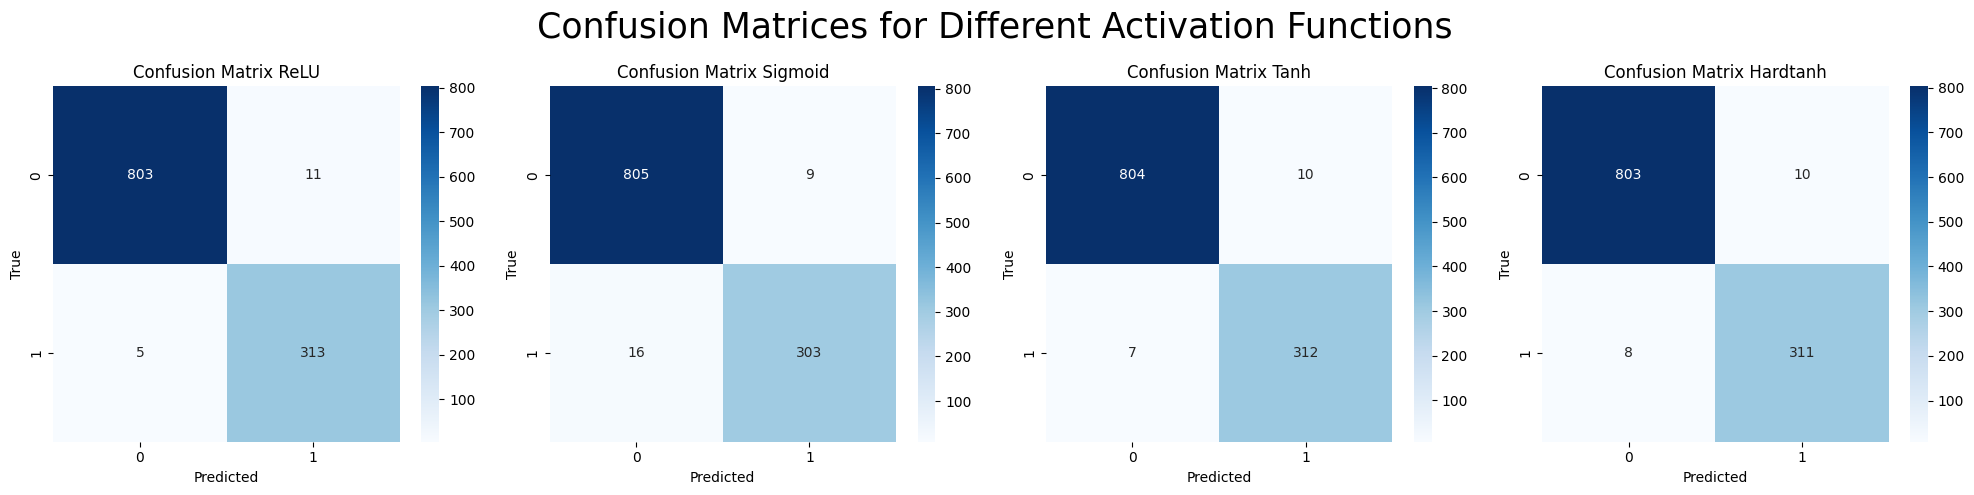

In [115]:
import seaborn as sns

fig, axes = plt.subplots(1, len(activation_functions), figsize=(20, 5))

for i, act in enumerate(activation_functions):
    act_name = type(act).__name__
    conf_matrix = mean_confusion_matrices[act_name]

    #Creates a heatmap for the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])

    axes[i].set_title(f'Confusion Matrix {act_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

fig.suptitle("Confusion Matrices for Different Activation Functions", fontsize=25)
plt.tight_layout()
plt.show()